In [1]:
%load_ext nb_mypy
%nb_mypy Off

Version 1.0.5


In [2]:
from __future__ import annotations
import numpy as np
import random
import copy

from typing import Tuple, List
from numpy import array, zeros

# from Big_Class import Big_Class  # already imported one NETfuncs is imported
from User_Variables import User_Variables  # already imported one NETfuncs is imported
from Network_Structure import Network_Structure  # already imported one NETfuncs is imported
from Big_Class import Big_Class
from Network_State import Network_State
from Networkx_Net import Networkx_Net
import matrix_functions, functions, statistics, plot_functions, solve

## Set up Network

In [3]:
## Parameters

# task_type='Iris_classification'
task_type='Regression'
M_values: np.ndarray = array([0.15, 0.2, 0.25, 0.1, 0.02, 0.3, 0.35, 0.15, 0.03, 0.25, 0.1, 0.15, 0.02, 0.3, 0.35, 0.15, 0.03])

Nin: int = 2
Ninter: int = 2
Nout: int = 2

# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec: np.ndarray = np.array([0.2])  # for allostery, regression and general_reg
# alpha_vec = np.array([0.1])  # for general_reg_allRsChange
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])
alpha: float = 0.5  # for network combine attempt

# resistance-pressure proportionality factor
gamma: np.ndarray = np.array([1.0])

# R_update: str = 'propto'
R_update: str = 'deltaR'
R_vec_i = array([1.9, 1., 0.85, 1.05, 0.9, 1., 0.85, 1.05, 0.9, 3., 0.85, 1.05, 0.9, 1, 0.85, 1.05, 1., 2.95, 0.55])

# training length
iterations = 4600  # number of sampled of p

supress_prints: bool = False  # whether to print information during training or not
bc_noise: float = 0.0  # noise to dual problem
# use_p_tag: bool = True  # use 1 or 2 sampled pressures at every time step
use_p_tag: bool = False
access_interNodes: bool = True  # access and change pressure at interNodes (nodes between input and output) or not
# access_interNodes: bool = False  # access and change pressure at interNodes (nodes between input and output) or not
stay_sample: int = 80  # how many loop iterations to stay under the same sampled p

## Networkx sizes
scale: float = 5.0
squish: float = 0.01

In [4]:
## Variables class - mostly user choices
Variabs = User_Variables(iterations,\
                         Nin, \
                         Nout, \
                         gamma, \
                         R_update, \
                         use_p_tag, \
                         supress_prints, \
                         bc_noise, \
                         access_interNodes, \
                         task_type, \
                         M_values, \
                         Ninter)
Variabs.assign_alpha_vec(alpha)
print('alpha_vec', Variabs.alpha_vec)
Variabs.create_dataset_and_targets(M_values)

alpha_vec [0.5 0.5]
input M mismatches output and input


In [5]:
## Assign input and output nodes a.f.o lattice size and row choice
input_nodes_arr, inter_nodes_arr, output_nodes_arr, ground_nodes_arr = matrix_functions.build_input_output_and_ground(Variabs.Nin, Variabs.Ninter, Variabs.Nout)

In [6]:
print('input_nodes_arr ', input_nodes_arr)
print('inter_nodes_arr ', inter_nodes_arr)
print('output_nodes_arr ', output_nodes_arr)
print('ground_nodes_arr ', ground_nodes_arr)

input_nodes_arr  [0 1]
inter_nodes_arr  [2 3]
output_nodes_arr  [4 5]
ground_nodes_arr  [6]


In [7]:
## Big Class containing all classes in Network Simulation
BigClass = Big_Class(Variabs)

In [8]:
## Structure class - build incidence matrices and 1d arrays of edges

Strctr = Network_Structure(input_nodes_arr, \
                           output_nodes_arr, \
                           inter_nodes_arr, \
                           ground_nodes_arr,)
Strctr.build_incidence()
Strctr.build_edges()
BigClass.add_Strctr(Strctr)  # add to big class

In [9]:
## Initiate internal flow network state class

if access_interNodes:
    State = Network_State(Variabs.Nin, Variabs.Nout, Ninter)
else:
    State = Network_State(Variabs.Nin, Variabs.Nout)
if task_type == 'Iris_classification':
    State.initiate_resistances(BigClass, R_vec_i)
else:
    State.initiate_resistances(BigClass)
BigClass.add_State(State)  # add to big class

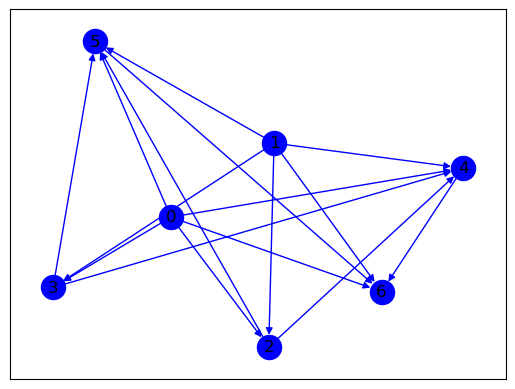

NET is ready


In [10]:
## build network graphics class and plot structure

NET = Networkx_Net(scale, squish)
NET.buildNetwork(BigClass)
NET.build_pos_lattice(BigClass, plot=True, node_labels=True)
BigClass.add_NET(NET)  # add to big class

## Train

In [11]:
for i in range(Variabs.iterations):
    print('i', i)
    # if task is classification and iteration # is beginning of epoch
    # draw output of network as output of mean of Irises
    if i % 15 == 0 and task_type == 'Iris_classification':
        targets_mat = zeros([3, 3])
        for j in range(3):
            State.draw_p_means_Iris(Variabs, j)
            # print('means[j]', State.input_drawn)
            State.solve_flow_given_problem(BigClass, "measure_for_mean")  # measure and don't change resistances
            # print('targets[j]', State.output)
            targets_mat[j] = State.output
        State.assign_targets_Iris(targets_mat)
        print(targets_mat)
    if use_p_tag:
        k = (i//stay_sample)*2 + i%2
    else:
        k = (i//stay_sample)
    print('k', k)
    State.draw_p_in_and_desired(Variabs, k)
    #print('p_drawn ', State.input_drawn)
    # print('desired output', State.desired)
    State.solve_flow_given_problem(BigClass, "measure")  # measure and don't change resistances
    # print('output meausred', State.output)
    if not i % 2 and use_p_tag:  # even iterations, take another sampled pressure and measure again
    # if not i % 2:  # even iterations, take another sampled pressure and measure again
        pass
    else:  # odd iterations, go to dual problem and update resistances
        State.calc_loss(BigClass)
        State.update_input_dual(BigClass)
        State.update_output_dual(BigClass)
        if access_interNodes:
            State.update_inter_dual(BigClass)
        State.solve_flow_given_problem(BigClass, "dual")  # measure and don't change resistances
        State.update_Rs(BigClass)

i 0
k 0
input_drawn [1.64077726 1.79456658]
desired output= [0.6050299  0.58965097]
output measured= [1.28825394 1.28825394]
loss= [[-0.68322403 -0.69860297]]
time= 1
input_dual_nxt= [1.13363516 1.23989027]
output_dual_nxt [-0.44008303 -0.44998901]
inter_dual_nxt= [1.02238169 1.02838891]
i 1
k 0
input_drawn [1.64077726 1.79456658]
desired output= [0.6050299  0.58965097]
output measured= [0.7266691 0.7182845]
loss= [[-0.1216392  -0.12863352]]
time= 2
input_dual_nxt= [0.2053209  0.22456553]
output_dual_nxt [-0.04419572 -0.04619773]
inter_dual_nxt= [0.1761649  0.16362489]
i 2
k 0
input_drawn [1.64077726 1.79456658]
desired output= [0.6050299  0.58965097]
output measured= [0.65819567 0.64778769]
loss= [[-0.05316577 -0.05813672]]
time= 3
input_dual_nxt= [0.0913113  0.09986987]
output_dual_nxt [-0.01749674 -0.01883013]
inter_dual_nxt= [0.07892094 0.0636782 ]
i 3
k 0
input_drawn [1.64077726 1.79456658]
desired output= [0.6050299  0.58965097]
output measured= [0.63048226 0.61878238]
loss= [[-0

i 70
k 0
input_drawn [1.64077726 1.79456658]
desired output= [0.6050299  0.58965097]
output measured= [0.60503094 0.58964648]
loss= [[-1.03965779e-06  4.49123149e-06]]
time= 71
input_dual_nxt= [-2.83163182e-06 -3.09703940e-06]
output_dual_nxt [-3.14512567e-07  1.32411942e-06]
inter_dual_nxt= [0.01976579 0.00796121]
i 71
k 0
input_drawn [1.64077726 1.79456658]
desired output= [0.6050299  0.58965097]
output measured= [0.6050297  0.58963691]
loss= [[2.08872777e-07 1.40590042e-05]]
time= 72
input_dual_nxt= [-1.17052040e-05 -1.28023276e-05]
output_dual_nxt [6.31871162e-08 4.14485392e-06]
inter_dual_nxt= [ 0.00432796 -0.01068482]
i 72
k 0
input_drawn [1.64077726 1.79456658]
desired output= [0.6050299  0.58965097]
output measured= [0.60503142 0.58964459]
loss= [[-1.51150560e-06  6.37983183e-06]]
time= 73
input_dual_nxt= [-3.99391948e-06 -4.36826777e-06]
output_dual_nxt [-4.57254186e-07  1.88091667e-06]
inter_dual_nxt= [-0.00331492  0.00443606]
i 73
k 0
input_drawn [1.64077726 1.79456658]
desi

i 156
k 1
input_drawn [1.20558268 1.84700016]
desired output= [0.55023743 0.48609569]
output measured= [0.55022868 0.48608667]
loss= [[8.75330185e-06 9.01450711e-06]]
time= 157
input_dual_nxt= [-1.07102814e-05 -1.64085730e-05]
output_dual_nxt [2.40815886e-06 2.19091588e-06]
inter_dual_nxt= [ 0.0001881  -0.00440643]
i 157
k 1
input_drawn [1.20558268 1.84700016]
desired output= [0.55023743 0.48609569]
output measured= [0.55023581 0.48609868]
loss= [[ 1.61958502e-06 -2.98953342e-06]]
time= 158
input_dual_nxt= [8.25793028e-07 1.26514745e-06]
output_dual_nxt [ 4.45576841e-07 -7.26604116e-07]
inter_dual_nxt= [-0.00989457 -0.00195192]
i 158
k 1
input_drawn [1.20558268 1.84700016]
desired output= [0.55023743 0.48609569]
output measured= [0.55024425 0.48612115]
loss= [[-6.81177915e-06 -2.54603213e-05]]
time= 159
input_dual_nxt= [1.94533427e-05 2.98032874e-05]
output_dual_nxt [-1.87407114e-06 -6.18840029e-06]
inter_dual_nxt= [0.00100412 0.0143044 ]
i 159
k 1
input_drawn [1.20558268 1.84700016]
d

i 267
k 3
input_drawn [0.60087767 0.0910696 ]
desired output= [0.10834557 0.15932638]
output measured= [0.12128558 0.14164162]
loss= [[-0.01294001  0.01768476]]
time= 268
input_dual_nxt= [-0.00142551 -0.00021605]
output_dual_nxt [-0.00078472  0.00125245]
inter_dual_nxt= [-0.01873166 -0.00397754]
i 268
k 3
input_drawn [0.60087767 0.0910696 ]
desired output= [0.10834557 0.15932638]
output measured= [0.12113729 0.14186838]
loss= [[-0.01279172  0.017458  ]]
time= 269
input_dual_nxt= [-0.00140193 -0.00021248]
output_dual_nxt [-0.00077478  0.00123837]
inter_dual_nxt= [-0.01829618 -0.00755562]
i 269
k 3
input_drawn [0.60087767 0.0910696 ]
desired output= [0.10834557 0.15932638]
output measured= [0.120985   0.14208333]
loss= [[-0.01263943  0.01724305]]
time= 270
input_dual_nxt= [-0.00138311 -0.00020962]
output_dual_nxt [-0.00076459  0.00122497]
inter_dual_nxt= [-0.00559504 -0.01845359]
i 270
k 3
input_drawn [0.60087767 0.0910696 ]
desired output= [0.10834557 0.15932638]
output measured= [0.120

output measured= [0.45115365 0.53324927]
loss= [[6.76928497e-05 1.47321714e-04]]
time= 386
input_dual_nxt= [-0.00018908 -0.00010074]
output_dual_nxt [1.52699381e-05 3.92795981e-05]
inter_dual_nxt= [-0.00508258 -0.01052861]
i 386
k 4
input_drawn [1.75877668 0.9370242 ]
desired output= [0.45122134 0.53339659]
output measured= [0.45113728 0.53321203]
loss= [[8.40586958e-05 1.84565079e-04]]
time= 387
input_dual_nxt= [-0.00023622 -0.00012585]
output_dual_nxt [1.89610058e-05 4.92061598e-05]
inter_dual_nxt= [-0.01684771  0.00908069]
i 387
k 4
input_drawn [1.75877668 0.9370242 ]
desired output= [0.45122134 0.53339659]
output measured= [0.45116436 0.53324219]
loss= [[5.69817229e-05 1.54400102e-04]]
time= 388
input_dual_nxt= [-1.85886712e-04 -9.90349428e-05]
output_dual_nxt [1.28540613e-05 4.11663242e-05]
inter_dual_nxt= [ 0.00826422 -0.00778733]
i 388
k 4
input_drawn [1.75877668 0.9370242 ]
desired output= [0.45122134 0.53339659]
output measured= [0.45118653 0.53328622]
loss= [[3.48084963e-05 1

i 508
k 6
input_drawn [1.63430956 0.06274462]
desired output= [0.25769536 0.41485185]
output measured= [0.26183385 0.41030574]
loss= [[-0.00413849  0.00454611]]
time= 509
input_dual_nxt= [-3.33091571e-04 -1.27880947e-05]
output_dual_nxt [-0.0005418   0.00093265]
inter_dual_nxt= [-0.00040668  0.00843598]
i 509
k 6
input_drawn [1.63430956 0.06274462]
desired output= [0.25769536 0.41485185]
output measured= [0.26162671 0.41086688]
loss= [[-0.00393135  0.00398497]]
time= 510
input_dual_nxt= [-4.38170662e-05 -1.68223047e-06]
output_dual_nxt [-0.00051427  0.00081865]
inter_dual_nxt= [-0.01107221 -0.01443091]
i 510
k 6
input_drawn [1.63430956 0.06274462]
desired output= [0.25769536 0.41485185]
output measured= [0.26117726 0.41084582]
loss= [[-0.0034819   0.00400603]]
time= 511
input_dual_nxt= [-4.28294609e-04 -1.64431420e-05]
output_dual_nxt [-0.0004547   0.00082293]
inter_dual_nxt= [-0.00997572  0.00039706]
i 511
k 6
input_drawn [1.63430956 0.06274462]
desired output= [0.25769536 0.41485185]

output measured= [0.48342745 0.56274721]
loss= [[4.81587666e-05 8.34224797e-05]]
time= 631
input_dual_nxt= [-1.20713701e-04 -6.85055319e-05]
output_dual_nxt [1.16406348e-05 2.34728841e-05]
inter_dual_nxt= [0.00408935 0.00735463]
i 631
k 7
input_drawn [1.83481619 1.04126589]
desired output= [0.48347561 0.56283064]
output measured= [0.4834949  0.56285234]
loss= [[-1.92952597e-05 -2.17002025e-05]]
time= 632
input_dual_nxt= [3.76095690e-05 2.13435883e-05]
output_dual_nxt [-4.66457986e-06 -6.10700485e-06]
inter_dual_nxt= [-0.01599674 -0.01035124]
i 632
k 7
input_drawn [1.83481619 1.04126589]
desired output= [0.48347561 0.56283064]
output measured= [0.48340598 0.56269696]
loss= [[6.96230824e-05 1.33680494e-04]]
time= 633
input_dual_nxt= [-0.00018651 -0.00010585]
output_dual_nxt [1.68281073e-05 3.76108036e-05]
inter_dual_nxt= [ 0.00754556 -0.00609914]
i 633
k 7
input_drawn [1.83481619 1.04126589]
desired output= [0.48347561 0.56283064]
output measured= [0.48342126 0.562732  ]
loss= [[5.434842

i 755
k 9
input_drawn [0.00381703 1.95061272]
desired output= [0.3906951  0.19601553]
output measured= [0.37474257 0.21247524]
loss= [[ 0.01595252 -0.01645971]]
time= 756
input_dual_nxt= [9.67967008e-07 4.94659755e-04]
output_dual_nxt [ 0.00298904 -0.00174864]
inter_dual_nxt= [ 5.68025404e-03 -1.48359063e-05]
i 756
k 9
input_drawn [0.00381703 1.95061272]
desired output= [0.3906951  0.19601553]
output measured= [0.37562145 0.21143079]
loss= [[ 0.01507364 -0.01541526]]
time= 757
input_dual_nxt= [6.51979974e-07 3.33181039e-04]
output_dual_nxt [ 0.00283099 -0.00162963]
inter_dual_nxt= [-0.00095195  0.006441  ]
i 757
k 9
input_drawn [0.00381703 1.95061272]
desired output= [0.3906951  0.19601553]
output measured= [0.37630125 0.21037268]
loss= [[ 0.01439385 -0.01435715]]
time= 758
input_dual_nxt= [-7.00415924e-08 -3.57933242e-05]
output_dual_nxt [ 0.00270821 -0.00151018]
inter_dual_nxt= [-0.01242445 -0.01127556]
i 758
k 9
input_drawn [0.00381703 1.95061272]
desired output= [0.3906951  0.19601

i 868
k 10
input_drawn [1.74578348 0.28718815]
desired output= [0.31930515 0.46516468]
output measured= [0.31928087 0.46494993]
loss= [[2.42801466e-05 2.14752766e-04]]
time= 869
input_dual_nxt= [-2.08649855e-04 -3.43237095e-05]
output_dual_nxt [3.87609317e-06 4.99246420e-05]
inter_dual_nxt= [-0.00481644  0.02021209]
i 869
k 10
input_drawn [1.74578348 0.28718815]
desired output= [0.31930515 0.46516468]
output measured= [0.31962972 0.46551665]
loss= [[-0.00032457 -0.00035197]]
time= 870
input_dual_nxt= [5.90539628e-04 9.71460566e-05]
output_dual_nxt [-5.18706494e-05 -8.19228703e-05]
inter_dual_nxt= [-0.00515771 -0.00917955]
i 870
k 10
input_drawn [1.74578348 0.28718815]
desired output= [0.31930515 0.46516468]
output measured= [0.31932479 0.46503758]
loss= [[-1.96400980e-05  1.27106716e-04]]
time= 871
input_dual_nxt= [-9.38067232e-05 -1.54315694e-05]
output_dual_nxt [-3.13578509e-06  2.95546997e-05]
inter_dual_nxt= [0.00321768 0.01810485]
i 871
k 10
input_drawn [1.74578348 0.28718815]
des

i 986
k 12
input_drawn [0.43691608 0.17503959]
desired output= [0.10054533 0.12673298]
output measured= [0.10076899 0.12637449]
loss= [[-0.00022366  0.00035849]]
time= 987
input_dual_nxt= [-2.94549063e-05 -1.18003776e-05]
output_dual_nxt [-1.12688294e-05  2.26518475e-05]
inter_dual_nxt= [-0.00089821  0.00495661]
i 987
k 12
input_drawn [0.43691608 0.17503959]
desired output= [0.10054533 0.12673298]
output measured= [0.10078796 0.12640625]
loss= [[-0.00024263  0.00032672]]
time= 988
input_dual_nxt= [-1.83709667e-05 -7.35987215e-06]
output_dual_nxt [-1.22270603e-05  2.06499272e-05]
inter_dual_nxt= [-0.00699388 -0.01356394]
i 988
k 12
input_drawn [0.43691608 0.17503959]
desired output= [0.10054533 0.12673298]
output measured= [0.10071805 0.12631399]
loss= [[-0.00017272  0.00041899]]
time= 989
input_dual_nxt= [-5.37990408e-05 -2.15532513e-05]
output_dual_nxt [-8.69806000e-06  2.64620317e-05]
inter_dual_nxt= [-0.00785113  0.00981673]
i 989
k 12
input_drawn [0.43691608 0.17503959]
desired out

i 1100
k 13
input_drawn [1.08501852 1.61496625]
desired output= [0.48574603 0.43275125]
output measured= [0.48563982 0.43262777]
loss= [[0.00010621 0.00012348]]
time= 1101
input_dual_nxt= [-0.00012461 -0.00018547]
output_dual_nxt [2.57893181e-05 2.67108255e-05]
inter_dual_nxt= [-0.00819091 -0.00213893]
i 1101
k 13
input_drawn [1.08501852 1.61496625]
desired output= [0.48574603 0.43275125]
output measured= [0.48570788 0.43270488]
loss= [[3.81525917e-05 4.63757462e-05]]
time= 1102
input_dual_nxt= [-4.58574059e-05 -6.82552064e-05]
output_dual_nxt [9.26550712e-06 1.00335058e-05]
inter_dual_nxt= [0.00214936 0.00164953]
i 1102
k 13
input_drawn [1.08501852 1.61496625]
desired output= [0.48574603 0.43275125]
output measured= [0.48569936 0.43269509]
loss= [[4.66716079e-05 5.61687430e-05]]
time= 1103
input_dual_nxt= [-5.57918426e-05 -8.30418480e-05]
output_dual_nxt [1.13341850e-05 1.21519695e-05]
inter_dual_nxt= [-0.00410829 -0.00822512]
i 1103
k 13
input_drawn [1.08501852 1.61496625]
desired ou

inter_dual_nxt= [0.00077107 0.00777898]
i 1220
k 15
input_drawn [0.66097115 1.03827974]
desired output= [0.30680162 0.26907076]
output measured= [0.30736927 0.26822609]
loss= [[-0.00056765  0.00084467]]
time= 1221
input_dual_nxt= [-9.15506523e-05 -1.43811402e-04]
output_dual_nxt [-8.72394227e-05  1.13281374e-04]
inter_dual_nxt= [-0.01232504  0.00023286]
i 1221
k 15
input_drawn [0.66097115 1.03827974]
desired output= [0.30680162 0.26907076]
output measured= [0.30735724 0.26831041]
loss= [[-0.00055562  0.00076035]]
time= 1222
input_dual_nxt= [-6.76614365e-05 -1.06285273e-04]
output_dual_nxt [-8.53864884e-05  1.02004995e-04]
inter_dual_nxt= [-0.000927    0.00327577]
i 1222
k 15
input_drawn [0.66097115 1.03827974]
desired output= [0.30680162 0.26907076]
output measured= [0.30730655 0.26834285]
loss= [[-0.00050493  0.00072791]]
time= 1223
input_dual_nxt= [-7.36920166e-05 -1.15758347e-04]
output_dual_nxt [-7.75836026e-05  9.76643870e-05]
inter_dual_nxt= [0.01281993 0.01615541]
i 1223
k 15
in

output measured= [0.13965516 0.1178586 ]
loss= [[ 0.00237842 -0.00224886]]
time= 1339
input_dual_nxt= [-1.65067308e-05 -3.36237760e-05]
output_dual_nxt [ 0.00016608 -0.00013252]
inter_dual_nxt= [ 0.00409248 -0.01380476]
i 1339
k 16
input_drawn [0.25481686 0.51905524]
desired output= [0.14203358 0.11560974]
output measured= [0.13976723 0.11790324]
loss= [[ 0.00226635 -0.0022935 ]]
time= 1340
input_dual_nxt= [3.45967728e-06 7.04727151e-06]
output_dual_nxt [ 0.00015838 -0.00013521]
inter_dual_nxt= [ 0.00060274 -0.03044764]
i 1340
k 16
input_drawn [0.25481686 0.51905524]
desired output= [0.14203358 0.11560974]
output measured= [0.13997107 0.11803384]
loss= [[ 0.00206251 -0.0024241 ]]
time= 1341
input_dual_nxt= [4.60698577e-05 9.38430869e-05]
output_dual_nxt [ 0.00014435 -0.00014306]
inter_dual_nxt= [-0.02062736 -0.00516373]
i 1341
k 16
input_drawn [0.25481686 0.51905524]
desired output= [0.14203358 0.11560974]
output measured= [0.14004829 0.11805922]
loss= [[ 0.00198529 -0.00244949]]
time=

output measured= [0.29816837 0.44841738]
loss= [[-0.00050297 -0.00061796]]
time= 1466
input_dual_nxt= [0.00095749 0.00011604]
output_dual_nxt [-7.49855540e-05 -1.38552414e-04]
inter_dual_nxt= [ 0.00072522 -0.00841343]
i 1466
k 18
input_drawn [1.70838124 0.20704106]
desired output= [0.2976654  0.44779942]
output measured= [0.29780695 0.44786584]
loss= [[-1.41548909e-04 -6.64267546e-05]]
time= 1467
input_dual_nxt= [1.77650861e-04 2.15297511e-05]
output_dual_nxt [-2.10771242e-05 -1.48751372e-05]
inter_dual_nxt= [ 0.00351253 -0.01539253]
i 1467
k 18
input_drawn [1.70838124 0.20704106]
desired output= [0.2976654  0.44779942]
output measured= [0.29744397 0.44731119]
loss= [[0.00022142 0.00048823]]
time= 1468
input_dual_nxt= [-6.06177135e-04 -7.34634370e-05]
output_dual_nxt [3.29307526e-05 1.09194472e-04]
inter_dual_nxt= [-0.00166071 -0.00294276]
i 1468
k 18
input_drawn [1.70838124 0.20704106]
desired output= [0.2976654  0.44779942]
output measured= [0.29746656 0.44734934]
loss= [[0.00019884 

i 1579
k 19
input_drawn [1.94832662 1.89968325]
desired output= [0.67218564 0.67704998]
output measured= [0.67217396 0.67703554]
loss= [[1.16779222e-05 1.44361617e-05]]
time= 1580
input_dual_nxt= [-2.54393823e-05 -2.48042438e-05]
output_dual_nxt [3.92479762e-06 4.88689728e-06]
inter_dual_nxt= [0.00309046 0.01589729]
i 1580
k 19
input_drawn [1.94832662 1.89968325]
desired output= [0.67218564 0.67704998]
output measured= [0.67221411 0.67707883]
loss= [[-2.84717628e-05 -2.88536236e-05]]
time= 1581
input_dual_nxt= [5.58442881e-05 5.44500382e-05]
output_dual_nxt [-9.56956041e-06 -9.76808890e-06]
inter_dual_nxt= [0.01131634 0.01103164]
i 1581
k 19
input_drawn [1.94832662 1.89968325]
desired output= [0.67218564 0.67704998]
output measured= [0.67222879 0.67709599]
loss= [[-4.31519884e-05 -4.60091201e-05]]
time= 1582
input_dual_nxt= [8.68574804e-05 8.46889321e-05]
output_dual_nxt [-1.45040046e-05 -1.55762953e-05]
inter_dual_nxt= [0.01524165 0.01016931]
i 1582
k 19
input_drawn [1.94832662 1.8996

output measured= [0.2451628  0.32277599]
loss= [[-0.02661933  0.02692663]]
time= 1696
input_dual_nxt= [-2.11094875e-04 -9.57212929e-06]
output_dual_nxt [-0.00326303  0.00434563]
inter_dual_nxt= [-0.00630038  0.00023413]
i 1696
k 21
input_drawn [1.37389076 0.06229929]
desired output= [0.21854347 0.34970262]
output measured= [0.24357882 0.32443107]
loss= [[-0.02503535  0.02527155]]
time= 1697
input_dual_nxt= [-1.62257424e-04 -7.35758765e-06]
output_dual_nxt [-0.00304904  0.00409944]
inter_dual_nxt= [0.01542386 0.00417525]
i 1697
k 21
input_drawn [1.37389076 0.06229929]
desired output= [0.21854347 0.34970262]
output measured= [0.2422628  0.32626981]
loss= [[-0.02371933  0.02343281]]
time= 1698
input_dual_nxt= [1.96824074e-04 8.92501765e-06]
output_dual_nxt [-0.00287316  0.00382271]
inter_dual_nxt= [ 0.00365883 -0.00456921]
i 1698
k 21
input_drawn [1.37389076 0.06229929]
desired output= [0.21854347 0.34970262]
output measured= [0.24081656 0.32767278]
loss= [[-0.02227308  0.02202984]]
time=

loss= [[-3.40326022e-05 -3.70798222e-05]]
time= 1818
input_dual_nxt= [7.04058892e-05 6.72652180e-05]
output_dual_nxt [-1.14930353e-05 -1.26859208e-05]
inter_dual_nxt= [ 0.01994367 -0.00903969]
i 1818
k 22
input_drawn [1.98012906 1.89179932]
desired output= [0.67537922 0.6842122 ]
output measured= [0.67540686 0.68424415]
loss= [[-2.76393128e-05 -3.19527813e-05]]
time= 1819
input_dual_nxt= [5.90000188e-05 5.63681415e-05]
output_dual_nxt [-9.33389076e-06 -1.09317519e-05]
inter_dual_nxt= [0.02247144 0.00999109]
i 1819
k 22
input_drawn [1.98012906 1.89179932]
desired output= [0.67537922 0.6842122 ]
output measured= [0.6754417  0.68428453]
loss= [[-6.24788207e-05 -7.23324920e-05]]
time= 1820
input_dual_nxt= [0.00013347 0.00012752]
output_dual_nxt [-2.11004005e-05 -2.47480027e-05]
inter_dual_nxt= [0.00600528 0.00657192]
i 1820
k 22
input_drawn [1.98012906 1.89179932]
desired output= [0.67537922 0.6842122 ]
output measured= [0.67542239 0.68426424]
loss= [[-4.31668452e-05 -5.20407870e-05]]
time

output measured= [0.05451913 0.02960584]
loss= [[-0.01299113  0.01303043]]
time= 1937
input_dual_nxt= [-2.45611756e-06 -2.23832606e-06]
output_dual_nxt [-0.00035413  0.00019289]
inter_dual_nxt= [ 0.00217609 -0.00663294]
i 1937
k 24
input_drawn [0.12498442 0.11390167]
desired output= [0.041528   0.04263627]
output measured= [0.05449899 0.02962171]
loss= [[-0.01297099  0.01301456]]
time= 1938
input_dual_nxt= [-2.72299134e-06 -2.48153532e-06]
output_dual_nxt [-0.00035345  0.00019276]
inter_dual_nxt= [-0.01095248 -0.00530743]
i 1938
k 24
input_drawn [0.12498442 0.11390167]
desired output= [0.041528   0.04263627]
output measured= [0.05447222 0.0296388 ]
loss= [[-0.01294422  0.01299748]]
time= 1939
input_dual_nxt= [-3.32785144e-06 -3.03276061e-06]
output_dual_nxt [-0.00035255  0.00019261]
inter_dual_nxt= [ 0.01374558 -0.00439955]
i 1939
k 24
input_drawn [0.12498442 0.11390167]
desired output= [0.041528   0.04263627]
output measured= [0.05445997 0.02965324]
loss= [[-0.01293197  0.01298303]]
t

i 2053
k 25
input_drawn [1.05492057 1.23647359]
desired output= [0.4055328 0.3873775]
output measured= [0.4056509  0.38725617]
loss= [[-0.00011809  0.00012134]]
time= 2054
input_dual_nxt= [-1.71157074e-06 -2.00613400e-06]
output_dual_nxt [-2.39520474e-05  2.34942221e-05]
inter_dual_nxt= [-0.00186589 -0.02050704]
i 2054
k 25
input_drawn [1.05492057 1.23647359]
desired output= [0.4055328 0.3873775]
output measured= [0.40564479 0.38728814]
loss= [[-1.11982675e-04  8.93616224e-05]]
time= 2055
input_dual_nxt= [1.19317066e-05 1.39851668e-05]
output_dual_nxt [-2.27125941e-05  1.73043483e-05]
inter_dual_nxt= [0.0022832 0.009953 ]
i 2055
k 25
input_drawn [1.05492057 1.23647359]
desired output= [0.4055328 0.3873775]
output measured= [0.40562619 0.38728837]
loss= [[-9.33836447e-05  8.91347662e-05]]
time= 2056
input_dual_nxt= [2.24111468e-06 2.62681305e-06]
output_dual_nxt [-1.89394259e-05  1.72604290e-05]
inter_dual_nxt= [-0.01643172 -0.00359776]
i 2056
k 25
input_drawn [1.05492057 1.23647359]
de

output measured= [0.21492686 0.24645398]
loss= [[-0.0321778   0.03284421]]
time= 2168
input_dual_nxt= [-3.57811255e-04 -3.61054207e-05]
output_dual_nxt [-0.00345794  0.00404729]
inter_dual_nxt= [-0.01456068  0.00212159]
i 2168
k 27
input_drawn [1.07384948 0.10835821]
desired output= [0.18274906 0.27929819]
output measured= [0.21359953 0.24775736]
loss= [[-0.03085047  0.03154083]]
time= 2169
input_dual_nxt= [-3.70671008e-04 -3.74030512e-05]
output_dual_nxt [-0.00329482  0.00390724]
inter_dual_nxt= [ 0.0005235 -0.0043487]
i 2169
k 27
input_drawn [1.07384948 0.10835821]
desired output= [0.18274906 0.27929819]
output measured= [0.21236238 0.2490547 ]
loss= [[-0.02961331  0.03024349]]
time= 2170
input_dual_nxt= [-3.38355460e-04 -3.41422079e-05]
output_dual_nxt [-0.00314438  0.00376614]
inter_dual_nxt= [0.01605775 0.013652  ]
i 2170
k 27
input_drawn [1.07384948 0.10835821]
desired output= [0.18274906 0.27929819]
output measured= [0.21138626 0.25057958]
loss= [[-0.0286372   0.02871861]]
time=

i 2287
k 28
input_drawn [0.89442941 0.77011945]
desired output= [0.2881883 0.3006193]
output measured= [0.28600494 0.3027661 ]
loss= [[ 0.00218336 -0.0021468 ]]
time= 2288
input_dual_nxt= [-1.63492199e-05 -1.40769658e-05]
output_dual_nxt [ 0.00031223 -0.00032499]
inter_dual_nxt= [-0.00246074  0.00192053]
i 2288
k 28
input_drawn [0.89442941 0.77011945]
desired output= [0.2881883 0.3006193]
output measured= [0.28615029 0.30262454]
loss= [[ 0.00203801 -0.00200525]]
time= 2289
input_dual_nxt= [-1.46541917e-05 -1.26175167e-05]
output_dual_nxt [ 0.00029159 -0.00030342]
inter_dual_nxt= [-0.00809346  0.00035506]
i 2289
k 28
input_drawn [0.89442941 0.77011945]
desired output= [0.2881883 0.3006193]
output measured= [0.28627905 0.302482  ]
loss= [[ 0.00190925 -0.0018627 ]]
time= 2290
input_dual_nxt= [-2.08144610e-05 -1.79216168e-05]
output_dual_nxt [ 0.00027329 -0.00028172]
inter_dual_nxt= [-0.01442504 -0.01166973]
i 2290
k 28
input_drawn [0.89442941 0.77011945]
desired output= [0.2881883 0.30061

i 2402
k 30
input_drawn [0.18139415 0.85699125]
desired output= [0.19860737 0.13104766]
output measured= [0.1954646  0.13419734]
loss= [[ 0.00314278 -0.00314967]]
time= 2403
input_dual_nxt= [6.25632995e-07 2.95578450e-06]
output_dual_nxt [ 0.00030715 -0.00021134]
inter_dual_nxt= [ 0.01535155 -0.01629698]
i 2403
k 30
input_drawn [0.18139415 0.85699125]
desired output= [0.19860737 0.13104766]
output measured= [0.19558633 0.13417322]
loss= [[ 0.00302105 -0.00312555]]
time= 2404
input_dual_nxt= [9.47865065e-06 4.47816035e-05]
output_dual_nxt [ 0.00029544 -0.00020968]
inter_dual_nxt= [-0.01067867  0.00453315]
i 2404
k 30
input_drawn [0.18139415 0.85699125]
desired output= [0.19860737 0.13104766]
output measured= [0.19565669 0.13412591]
loss= [[ 0.00295068 -0.00307825]]
time= 2405
input_dual_nxt= [1.15697937e-05 5.46611466e-05]
output_dual_nxt [ 0.00028866 -0.00020644]
inter_dual_nxt= [0.01912131 0.02583875]
i 2405
k 30
input_drawn [0.18139415 0.85699125]
desired output= [0.19860737 0.131047

loss= [[-0.00773181  0.00766752]]
time= 2519
input_dual_nxt= [9.08454100e-06 1.88274263e-05]
output_dual_nxt [-0.00064665  0.00046604]
inter_dual_nxt= [-0.01023082 -0.00722472]
i 2519
k 31
input_drawn [0.2826238  0.58572895]
desired output= [0.15953936 0.12922884]
output measured= [0.16717578 0.12171484]
loss= [[-0.00763642  0.007514  ]]
time= 2520
input_dual_nxt= [1.72998087e-05 3.58533109e-05]
output_dual_nxt [-0.00063831  0.00045728]
inter_dual_nxt= [-0.01631085 -0.00640815]
i 2520
k 31
input_drawn [0.2826238  0.58572895]
desired output= [0.15953936 0.12922884]
output measured= [0.1670849  0.12187377]
loss= [[-0.00754554  0.00735508]]
time= 2521
input_dual_nxt= [2.69144867e-05 5.57794295e-05]
output_dual_nxt [-0.00063037  0.0004482 ]
inter_dual_nxt= [-0.01347921 -0.01668199]
i 2521
k 31
input_drawn [0.2826238  0.58572895]
desired output= [0.15953936 0.12922884]
output measured= [0.16701654 0.1220514 ]
loss= [[-0.00747718  0.00717744]]
time= 2522
input_dual_nxt= [4.23556606e-05 8.778

i 2634
k 32
input_drawn [1.24645678 1.80584305]
desired output= [0.54813713 0.4921985 ]
output measured= [0.54808109 0.49210322]
loss= [[5.60338058e-05 9.52790148e-05]]
time= 2635
input_dual_nxt= [-9.43024456e-05 -1.36623603e-04]
output_dual_nxt [1.53555348e-05 2.34435551e-05]
inter_dual_nxt= [-0.0001885  -0.00360668]
i 2635
k 32
input_drawn [1.24645678 1.80584305]
desired output= [0.54813713 0.4921985 ]
output measured= [0.54812035 0.49215196]
loss= [[1.67769968e-05 4.65360928e-05]]
time= 2636
input_dual_nxt= [-3.94585149e-05 -5.71667515e-05]
output_dual_nxt [4.59790667e-06 1.14514147e-05]
inter_dual_nxt= [0.00264214 0.01043581]
i 2636
k 32
input_drawn [1.24645678 1.80584305]
desired output= [0.54813713 0.4921985 ]
output measured= [0.54808129 0.49210796]
loss= [[5.58346782e-05 9.05415345e-05]]
time= 2637
input_dual_nxt= [-9.12258114e-05 -1.32166233e-04]
output_dual_nxt [1.53009713e-05 2.22781049e-05]
inter_dual_nxt= [-0.0071131   0.00709419]
i 2637
k 32
input_drawn [1.24645678 1.8058

output measured= [0.2663962 0.2898461]
loss= [[ 0.00308648 -0.00290873]]
time= 2760
input_dual_nxt= [-7.72979111e-05 -6.17842356e-05]
output_dual_nxt [ 0.00041111 -0.00042154]
inter_dual_nxt= [ 0.00244942 -0.0160167 ]
i 2760
k 34
input_drawn [0.86969162 0.69514469]
desired output= [0.26948268 0.28693737]
output measured= [0.26655219 0.2896385 ]
loss= [[ 0.00293049 -0.00270112]]
time= 2761
input_dual_nxt= [-9.97396679e-05 -7.97219363e-05]
output_dual_nxt [ 0.00039056 -0.00039117]
inter_dual_nxt= [-0.00596338  0.00311395]
i 2761
k 34
input_drawn [0.86969162 0.69514469]
desired output= [0.26948268 0.28693737]
output measured= [0.26673012 0.28948149]
loss= [[ 0.00275256 -0.00254411]]
time= 2762
input_dual_nxt= [-9.06449615e-05 -7.24525357e-05]
output_dual_nxt [ 0.0003671  -0.00036824]
inter_dual_nxt= [-0.00019057  0.00816382]
i 2762
k 34
input_drawn [0.86969162 0.69514469]
desired output= [0.26948268 0.28693737]
output measured= [0.26691273 0.28935629]
loss= [[ 0.00256995 -0.00241892]]
tim

i 2877
k 35
input_drawn [1.06857739 1.18668718]
desired output= [0.39762404 0.38581306]
output measured= [0.39762581 0.38580678]
loss= [[-1.76710182e-06  6.28475161e-06]]
time= 2878
input_dual_nxt= [-2.41372920e-06 -2.68051854e-06]
output_dual_nxt [-3.51322648e-07  1.21234989e-06]
inter_dual_nxt= [0.00131933 0.01049074]
i 2878
k 35
input_drawn [1.06857739 1.18668718]
desired output= [0.39762404 0.38581306]
output measured= [0.39762332 0.38580244]
loss= [[7.23672629e-07 1.06281332e-05]]
time= 2879
input_dual_nxt= [-6.06514151e-06 -6.73552121e-06]
output_dual_nxt [1.43874557e-07 2.05017984e-06]
inter_dual_nxt= [-0.00669481 -0.00637544]
i 2879
k 35
input_drawn [1.06857739 1.18668718]
desired output= [0.39762404 0.38581306]
output measured= [0.39762511 0.38580913]
loss= [[-1.06241616e-06  3.93427762e-06]]
time= 2880
input_dual_nxt= [-1.53440311e-06 -1.70400059e-06]
output_dual_nxt [-2.11221669e-07  7.58940115e-07]
inter_dual_nxt= [-0.00211881  0.00146215]
i 2880
k 36
input_drawn [0.2016570

output measured= [0.22503538 0.22379638]
loss= [[-0.02388201  0.02456132]]
time= 2989
input_dual_nxt= [-0.00028683 -0.00012649]
output_dual_nxt [-0.00268715  0.00274837]
inter_dual_nxt= [0.00734975 0.01137334]
i 2989
k 37
input_drawn [0.84446289 0.37241972]
desired output= [0.20115338 0.24835769]
output measured= [0.22420737 0.22483666]
loss= [[-0.02305399  0.02352104]]
time= 2990
input_dual_nxt= [-1.97202080e-04 -8.69688236e-05]
output_dual_nxt [-0.00258444  0.0026442 ]
inter_dual_nxt= [-0.00545451  0.0053623 ]
i 2990
k 37
input_drawn [0.84446289 0.37241972]
desired output= [0.20115338 0.24835769]
output measured= [0.22334519 0.22577272]
loss= [[-0.02219181  0.02258497]]
time= 2991
input_dual_nxt= [-1.66004398e-04 -7.32102176e-05]
output_dual_nxt [-0.00247822  0.00254954]
inter_dual_nxt= [ 0.01161106 -0.00639622]
i 2991
k 37
input_drawn [0.84446289 0.37241972]
desired output= [0.20115338 0.24835769]
output measured= [0.22248631 0.22664376]
loss= [[-0.02133293  0.02171393]]
time= 2992


i 3107
k 38
input_drawn [1.14740588 0.08552665]
desired output= [0.18921621 0.29540413]
output measured= [0.19063388 0.29357351]
loss= [[-0.00141767  0.00183062]]
time= 3108
input_dual_nxt= [-2.36910494e-04 -1.76591061e-05]
output_dual_nxt [-0.00013513  0.00026871]
inter_dual_nxt= [-0.01049894  0.00285312]
i 3108
k 38
input_drawn [1.14740588 0.08552665]
desired output= [0.18921621 0.29540413]
output measured= [0.19058365 0.29364001]
loss= [[-0.00136744  0.00176412]]
time= 3109
input_dual_nxt= [-2.27578579e-04 -1.69635131e-05]
output_dual_nxt [-0.00013031  0.00025901]
inter_dual_nxt= [0.0119502  0.00016131]
i 3109
k 38
input_drawn [1.14740588 0.08552665]
desired output= [0.18921621 0.29540413]
output measured= [0.19058025 0.29384632]
loss= [[-0.00136404  0.00155781]]
time= 3110
input_dual_nxt= [-1.11167609e-04 -8.28633873e-06]
output_dual_nxt [-0.00012998  0.00022888]
inter_dual_nxt= [-0.00698578 -0.00910518]
i 3110
k 38
input_drawn [1.14740588 0.08552665]
desired output= [0.18921621 0.

output measured= [0.47096529 0.356254  ]
loss= [[ 0.00024851 -0.00104057]]
time= 3234
input_dual_nxt= [0.00027067 0.00073007]
output_dual_nxt [ 5.85197849e-05 -1.85353440e-04]
inter_dual_nxt= [-0.0146904   0.00843415]
i 3234
k 40
input_drawn [0.68346587 1.84346961]
desired output= [0.4712138  0.35521343]
output measured= [0.47090962 0.35607812]
loss= [[ 0.00030419 -0.00086469]]
time= 3235
input_dual_nxt= [0.00019154 0.00051664]
output_dual_nxt [ 7.16221029e-05 -1.53948441e-04]
inter_dual_nxt= [-8.63939502e-06  1.46417895e-03]
i 3235
k 40
input_drawn [0.68346587 1.84346961]
desired output= [0.4712138  0.35521343]
output measured= [0.47089145 0.35592169]
loss= [[ 0.00032235 -0.00070826]]
time= 3236
input_dual_nxt= [0.00013188 0.00035571]
output_dual_nxt [ 7.58968923e-05 -1.26043292e-04]
inter_dual_nxt= [-0.01928222 -0.01472876]
i 3236
k 40
input_drawn [0.68346587 1.84346961]
desired output= [0.4712138  0.35521343]
output measured= [0.47112943 0.35606728]
loss= [[ 8.4375307e-05 -8.5385469

i 3354
k 41
input_drawn [0.59121226 1.05923378]
desired output= [0.3005286  0.25372644]
output measured= [0.30069195 0.25350763]
loss= [[-0.00016336  0.00021881]]
time= 3355
input_dual_nxt= [-1.63932937e-05 -2.93707211e-05]
output_dual_nxt [-2.45598408e-05  2.77352602e-05]
inter_dual_nxt= [-0.00126066 -0.01888813]
i 3355
k 41
input_drawn [0.59121226 1.05923378]
desired output= [0.3005286  0.25372644]
output measured= [0.3007283  0.25358044]
loss= [[-0.0001997   0.00014601]]
time= 3356
input_dual_nxt= [1.58727039e-05 2.84380166e-05]
output_dual_nxt [-3.00281052e-05  1.85122732e-05]
inter_dual_nxt= [-0.01010368 -0.00693848]
i 3356
k 41
input_drawn [0.59121226 1.05923378]
desired output= [0.3005286  0.25372644]
output measured= [0.30074142 0.25363021]
loss= [[-2.12821218e-04  9.62307855e-05]]
time= 3357
input_dual_nxt= [3.44648467e-05 6.17482623e-05]
output_dual_nxt [-3.20020773e-05  1.22035173e-05]
inter_dual_nxt= [-0.01069827  0.00446303]
i 3357
k 41
input_drawn [0.59121226 1.05923378]


output measured= [0.2069016  0.20673996]
loss= [[-0.00549898  0.00571231]]
time= 3482
input_dual_nxt= [-6.81136017e-05 -5.63275352e-05]
output_dual_nxt [-0.00056887  0.00059048]
inter_dual_nxt= [0.00508174 0.01360957]
i 3482
k 43
input_drawn [0.63857688 0.52808045]
desired output= [0.20140262 0.21245227]
output measured= [0.20674503 0.20694593]
loss= [[-0.00534241  0.00550633]]
time= 3483
input_dual_nxt= [-5.23387352e-05 -4.32822795e-05]
output_dual_nxt [-0.00055226  0.00056976]
inter_dual_nxt= [-0.00316853  0.01860804]
i 3483
k 43
input_drawn [0.63857688 0.52808045]
desired output= [0.20140262 0.21245227]
output measured= [0.20659408 0.20714616]
loss= [[-0.00519145  0.00530611]]
time= 3484
input_dual_nxt= [-3.66071547e-05 -3.02728198e-05]
output_dual_nxt [-0.00053626  0.00054957]
inter_dual_nxt= [ 0.01867085 -0.00891352]
i 3484
k 43
input_drawn [0.63857688 0.52808045]
desired output= [0.20140262 0.21245227]
output measured= [0.2064281  0.20732033]
loss= [[-0.00502548  0.00513193]]
tim

i 3601
k 45
input_drawn [1.04178162 0.13253017]
desired output= [0.18277328 0.27369842]
output measured= [0.22484903 0.22741642]
loss= [[-0.04207575  0.046282  ]]
time= 3602
input_dual_nxt= [-0.002191   -0.00027873]
output_dual_nxt [-0.00473035  0.00526264]
inter_dual_nxt= [-0.00813317 -0.01362616]
i 3602
k 45
input_drawn [1.04178162 0.13253017]
desired output= [0.18277328 0.27369842]
output measured= [0.22325867 0.22925526]
loss= [[-0.04048539  0.04444316]]
time= 3603
input_dual_nxt= [-0.00206157 -0.00026226]
output_dual_nxt [-0.00451936  0.00509441]
inter_dual_nxt= [0.0134933  0.00289457]
i 3603
k 45
input_drawn [1.04178162 0.13253017]
desired output= [0.18277328 0.27369842]
output measured= [0.22189422 0.23120217]
loss= [[-0.03912094  0.04249625]]
time= 3604
input_dual_nxt= [-0.00175817 -0.00022367]
output_dual_nxt [-0.00434036  0.00491261]
inter_dual_nxt= [-0.01363873 -0.00828362]
i 3604
k 45
input_drawn [1.04178162 0.13253017]
desired output= [0.18277328 0.27369842]
output measure

output measured= [0.29372108 0.43341639]
loss= [[-7.03457389e-05 -3.06963521e-04]]
time= 3721
input_dual_nxt= [3.08621792e-04 4.55265120e-05]
output_dual_nxt [-1.03310133e-05 -6.65215111e-05]
inter_dual_nxt= [ 0.00323378 -0.01178817]
i 3721
k 46
input_drawn [1.63590892 0.241322  ]
desired output= [0.29365074 0.43310943]
output measured= [0.29364408 0.43324405]
loss= [[ 6.65306571e-06 -1.34619179e-04]]
time= 3722
input_dual_nxt= [1.04670453e-04 1.54405190e-05]
output_dual_nxt [ 9.76816695e-07 -2.91614791e-05]
inter_dual_nxt= [0.00444498 0.01538893]
i 3722
k 46
input_drawn [1.63590892 0.241322  ]
desired output= [0.29365074 0.43310943]
output measured= [0.29372346 0.43343968]
loss= [[-7.27203616e-05 -3.30254360e-04]]
time= 3723
input_dual_nxt= [3.29614971e-04 4.86233323e-05]
output_dual_nxt [-1.06798381e-05 -7.15726729e-05]
inter_dual_nxt= [-0.00045272  0.00014002]
i 3723
k 46
input_drawn [1.63590892 0.241322  ]
desired output= [0.29365074 0.43310943]
output measured= [0.2936854  0.43335

i 3843
k 48
input_drawn [0.26843149 0.79123689]
desired output= [0.1985121  0.14623156]
output measured= [0.19714806 0.14780831]
loss= [[ 0.00136404 -0.00157675]]
time= 3844
input_dual_nxt= [2.85489090e-05 8.41516414e-05]
output_dual_nxt [ 0.00013446 -0.00011653]
inter_dual_nxt= [-0.01311126 -0.00174662]
i 3844
k 48
input_drawn [0.26843149 0.79123689]
desired output= [0.1985121  0.14623156]
output measured= [0.19719101 0.14780464]
loss= [[ 0.00132109 -0.00157308]]
time= 3845
input_dual_nxt= [3.38210420e-05 9.96919425e-05]
output_dual_nxt [ 0.00013025 -0.00011625]
inter_dual_nxt= [-0.01514308 -0.01097956]
i 3845
k 48
input_drawn [0.26843149 0.79123689]
desired output= [0.1985121  0.14623156]
output measured= [0.19724825 0.14782738]
loss= [[ 0.00126385 -0.00159581]]
time= 3846
input_dual_nxt= [4.45552110e-05 1.31332309e-04]
output_dual_nxt [ 0.00012465 -0.00011795]
inter_dual_nxt= [0.00039322 0.01003574]
i 3846
k 48
input_drawn [0.26843149 0.79123689]
desired output= [0.1985121  0.146231

output measured= [0.3017207  0.46061008]
loss= [[-0.00135914  0.00038606]]
time= 3963
input_dual_nxt= [8.64133883e-04 8.25858983e-05]
output_dual_nxt [-2.05040082e-04  8.89121748e-05]
inter_dual_nxt= [ 0.01305047 -0.01217065]
i 3963
k 49
input_drawn [1.77608777 0.16974199]
desired output= [0.30036156 0.46099614]
output measured= [0.30150547 0.46054098]
loss= [[-0.00114391  0.00045516]]
time= 3964
input_dual_nxt= [6.11636439e-04 5.84545355e-05]
output_dual_nxt [-0.00017245  0.00010481]
inter_dual_nxt= [-0.00670435  0.00317113]
i 3964
k 49
input_drawn [1.77608777 0.16974199]
desired output= [0.30036156 0.46099614]
output measured= [0.30130887 0.46045244]
loss= [[-0.00094731  0.0005437 ]]
time= 3965
input_dual_nxt= [3.58414880e-04 3.42539685e-05]
output_dual_nxt [-0.00014272  0.00012518]
inter_dual_nxt= [0.00612806 0.02767422]
i 3965
k 49
input_drawn [1.77608777 0.16974199]
desired output= [0.30036156 0.46099614]
output measured= [0.30132694 0.46088851]
loss= [[-0.00096537  0.00010764]]
t

loss= [[2.25505971e-05 2.90725724e-05]]
time= 4074
input_dual_nxt= [-3.25227712e-05 -4.64819689e-05]
output_dual_nxt [6.19174092e-06 7.19625283e-06]
inter_dual_nxt= [ 0.00145009 -0.00050564]
i 4074
k 50
input_drawn [1.26000676 1.8008181 ]
desired output= [0.54916463 0.4950835 ]
output measured= [0.54915019 0.49506206]
loss= [[1.44463660e-05 2.14363687e-05]]
time= 4075
input_dual_nxt= [-2.2606244e-05 -3.2309139e-05]
output_dual_nxt [3.96661228e-06 5.30616644e-06]
inter_dual_nxt= [-0.01060979 -0.02910877]
i 4075
k 50
input_drawn [1.26000676 1.8008181 ]
desired output= [0.54916463 0.4950835 ]
output measured= [0.54918836 0.49516504]
loss= [[-2.37314998e-05 -8.15449324e-05]]
time= 4076
input_dual_nxt= [6.63245079e-05 9.47918522e-05]
output_dual_nxt [-6.51653178e-06 -2.01891000e-05]
inter_dual_nxt= [ 0.02531583 -0.00475882]
i 4076
k 50
input_drawn [1.26000676 1.8008181 ]
desired output= [0.54916463 0.4950835 ]
output measured= [0.54915266 0.49508823]
loss= [[ 1.19734681e-05 -4.73012215e-06]

output measured= [0.4554107 0.4129857]
loss= [[ 0.00010378 -0.00011311]]
time= 4189
input_dual_nxt= [4.9379706e-06 6.9285546e-06]
output_dual_nxt [ 2.36308464e-05 -2.33573283e-05]
inter_dual_nxt= [ 0.00828627 -0.01803948]
i 4189
k 52
input_drawn [1.05780201 1.48422086]
desired output= [0.45551447 0.41287259]
output measured= [0.45542673 0.41298544]
loss= [[ 8.77480027e-05 -1.12847871e-04]]
time= 4190
input_dual_nxt= [1.32753457e-05 1.86268742e-05]
output_dual_nxt [ 1.99813928e-05 -2.33022637e-05]
inter_dual_nxt= [-0.01703831  0.00014793]
i 4190
k 52
input_drawn [1.05780201 1.48422086]
desired output= [0.45551447 0.41287259]
output measured= [0.45545593 0.41300407]
loss= [[ 5.85404245e-05 -1.31476656e-04]]
time= 4191
input_dual_nxt= [3.85760460e-05 5.41267381e-05]
output_dual_nxt [ 1.33312919e-05 -2.71501967e-05]
inter_dual_nxt= [ 0.00330009 -0.00711439]
i 4191
k 52
input_drawn [1.05780201 1.48422086]
desired output= [0.45551447 0.41287259]
output measured= [0.45546054 0.41298782]
loss=

i 4311
k 53
input_drawn [1.89201737 0.06219042]
desired output= [0.29624069 0.47922338]
output measured= [0.29621008 0.47885707]
loss= [[3.06097102e-05 3.66315453e-04]]
time= 4312
input_dual_nxt= [-3.75494652e-04 -1.23424717e-05]
output_dual_nxt [4.53345235e-06 8.77063722e-05]
inter_dual_nxt= [0.00789788 0.00345679]
i 4312
k 53
input_drawn [1.89201737 0.06219042]
desired output= [0.29624069 0.47922338]
output measured= [0.2963202  0.47914437]
loss= [[-7.95089601e-05  7.90169572e-05]]
time= 4313
input_dual_nxt= [4.6543905e-07 1.5298935e-08]
output_dual_nxt [-1.17800554e-05  1.89302650e-05]
inter_dual_nxt= [0.008278  0.0060577]
i 4313
k 53
input_drawn [1.89201737 0.06219042]
desired output= [0.29624069 0.47922338]
output measured= [0.29639532 0.47938022]
loss= [[-0.00015463 -0.00015684]]
time= 4314
input_dual_nxt= [2.94651277e-04 9.68515801e-06]
output_dual_nxt [-2.29155087e-05 -3.75929558e-05]
inter_dual_nxt= [-0.00776126 -0.0036828 ]
i 4314
k 53
input_drawn [1.89201737 0.06219042]
desi

i 4423
k 55
input_drawn [1.83850586 1.19341021]
desired output= [0.51445792 0.57896749]
output measured= [0.51421578 0.57914285]
loss= [[ 0.00024214 -0.00017537]]
time= 4424
input_dual_nxt= [-6.13845116e-05 -3.98458902e-05]
output_dual_nxt [ 6.22568229e-05 -5.07810625e-05]
inter_dual_nxt= [ 0.0128141  -0.00609196]
i 4424
k 55
input_drawn [1.83850586 1.19341021]
desired output= [0.51445792 0.57896749]
output measured= [0.51429363 0.57914327]
loss= [[ 0.00016429 -0.00017578]]
time= 4425
input_dual_nxt= [1.05642904e-05 6.85748806e-06]
output_dual_nxt [ 4.22466499e-05 -5.09015548e-05]
inter_dual_nxt= [0.002524   0.00298662]
i 4425
k 55
input_drawn [1.83850586 1.19341021]
desired output= [0.51445792 0.57896749]
output measured= [0.51434568 0.579131  ]
loss= [[ 0.00011224 -0.00016351]]
time= 4426
input_dual_nxt= [4.71349131e-05 3.05961964e-05]
output_dual_nxt [ 2.88643196e-05 -4.73475157e-05]
inter_dual_nxt= [0.00224881 0.01248075]
i 4426
k 55
input_drawn [1.83850586 1.19341021]
desired outp

output measured= [0.32786741 0.20526563]
loss= [[ 0.0019883  -0.00234277]]
time= 4548
input_dual_nxt= [3.84802521e-05 2.63449660e-04]
output_dual_nxt [ 0.00032595 -0.00024044]
inter_dual_nxt= [ 0.00659543 -0.00333298]
i 4548
k 56
input_drawn [0.21711432 1.48644282]
desired output= [0.32985571 0.20292286]
output measured= [0.32794345 0.2051197 ]
loss= [[ 0.00191226 -0.00219683]]
time= 4549
input_dual_nxt= [3.08924521e-05 2.11500849e-04]
output_dual_nxt [ 0.00031356 -0.00022531]
inter_dual_nxt= [0.01176211 0.00278718]
i 4549
k 56
input_drawn [0.21711432 1.48644282]
desired output= [0.32985571 0.20292286]
output measured= [0.32794205 0.20490568]
loss= [[ 0.00191367 -0.00198282]]
time= 4550
input_dual_nxt= [7.50695995e-06 5.13953504e-05]
output_dual_nxt [ 0.00031379 -0.00020315]
inter_dual_nxt= [0.00996761 0.00071391]
i 4550
k 56
input_drawn [0.21711432 1.48644282]
desired output= [0.32985571 0.20292286]
output measured= [0.32797796 0.20473627]
loss= [[ 0.00187775 -0.00181341]]
time= 4551


## Plots

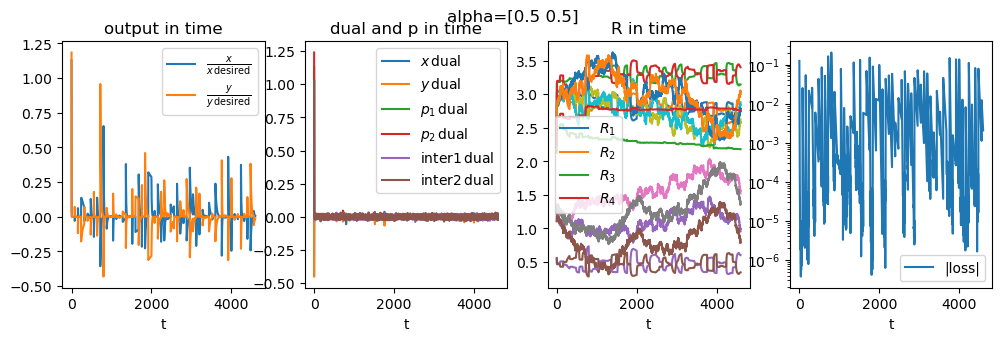

In [12]:
if hasattr(Variabs, 'M'):
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, Variabs.M)
else:
        plot_functions.plot_importants(State, Variabs, State.desired_in_t)

## Statistics

### Error

In [13]:
final_err = statistics.final_err(BigClass, 40)
print('final_err', final_err)

final_err 0.01620745561880933


### Accuracy

In [14]:
accuracy = zeros(np.shape(Variabs.dataset)[0])
for i, datapoint in enumerate(Variabs.dataset):
    State.draw_p_in_and_desired(Variabs, i)
    State.solve_flow_given_problem(BigClass, "measure")  # measure and don't change resistances
    accuracy[i] = statistics.calculate_accuracy(State.output, State.target_mat, Variabs.targets[i])

input_drawn [1.64077726 1.79456658]
desired output= [0.6050299  0.58965097]
output measured= [0.72032505 0.48508131]


AttributeError: 'Network_State' object has no attribute 'target_mat'

In [ ]:
Variabs.targets

In [ ]:
np.mean(accuracy)

## Checks

In [ ]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils import shuffle
from numpy.linalg import norm

In [ ]:
# Load the Iris dataset
iris = load_iris()
dataset, numerical_targets = shuffle(iris['data'], iris['target'], random_state=42)
# Min-Max Scale dataset to [0, 4]
min_max_scaler = MinMaxScaler(feature_range=(0, 4))
dataset = min_max_scaler.fit_transform(dataset)
# One-hot encode the label
encoder = OneHotEncoder(sparse_output=False, categories='auto')
targets_reshaped = numerical_targets.reshape(-1, 1)  # Reshape for the encoder
targets = encoder.fit_transform(targets_reshaped)

In [ ]:
State.inter_dual_in_t

In [ ]:
State.inter_in_t

In [ ]:
for i in range(iterations):
    k = ((i // 2) % stay_sample/2) + 1 + (i // stay_sample) * 2
    print(f"i: {i}, k: {k}")

In [ ]:
for i in range(18):
    k = (i % 6) // 2 + (i // 6) * 2
    print(f"i: {i}, k: {k}")

In [ ]:
np.shape(State.output_in_t[:])[0]

In [21]:
np.mean(np.mean(np.abs(State.loss_in_t[0:stay_sample:]), axis=1), axis=1)

array([6.90913500e-01, 1.25136361e-01, 5.56512461e-02, 2.72918810e-02,
       1.39193268e-02, 7.22781578e-03, 3.79161311e-03, 1.99535204e-03,
       1.05656025e-03, 5.60562211e-04, 2.94018188e-04, 1.66812996e-04,
       1.19496483e-04, 8.93423707e-05, 7.05826406e-05, 5.34420989e-05,
       4.03033275e-05, 3.39182487e-05, 2.12240857e-05, 1.63095813e-05,
       8.51343721e-06, 5.49934514e-06, 3.27479687e-06, 4.26601664e-06,
       5.07271742e-06, 6.09090448e-06, 4.56585740e-06, 3.54925175e-06,
       1.86103642e-06, 2.00552603e-06, 2.45489870e-06, 3.12222789e-06,
       5.74916810e-06, 5.57106424e-06, 4.75786675e-06, 5.08446987e-06,
       1.80530306e-06, 3.77747707e-07, 8.96520752e-07, 2.11244850e-06,
       1.90873960e-06, 1.58118309e-06, 8.12781340e-07, 2.05108695e-06,
       3.06187950e-06, 7.32841305e-07, 5.47420537e-07, 2.22663649e-06,
       4.23868269e-06, 3.06474548e-06, 2.86746733e-06, 1.91711403e-06,
       2.95956337e-06, 1.78102388e-06, 2.26986190e-06, 9.12978398e-07,
      

In [22]:
State.loss_in_t[3280]

array([[-0.01505533,  0.0159139 ]])

In [ ]:
0, State.t, State.t-1

In [ ]:
np.shape(np.linspace(0, np.shape(State.output_in_t)[0], State.t-1).T)

In [24]:
np.mean(np.abs(State.loss_in_t[3280]), axis=1)

array([0.01548461])